In [282]:
# read cities.txt (id, lat, lon) and plot every city on a map
import matplotlib.pyplot as plt
import numpy as np
from math import radians, cos, sin, sqrt, atan2
import networkx as nx
import pandas as pd
import os, time, sys, random, math, heapq
from concurrent.futures import ThreadPoolExecutor
import itertools as it
import scienceplots
from collections import deque
from matplotlib import animation
from IPython.display import Video, display
import re

In [247]:
# plt theme latex
plt.style.use(['science','no-latex'])
# size of the plot
plt.rcParams["figure.figsize"] = (6*0.6, 4*0.6)

# dpi
plt.rcParams["figure.dpi"] = 600

## Part 1: Get Data

In [248]:
# read us-cities-top-1k.csv
df = pd.read_csv('us-cities-top-1k.csv') # cols = ['City', 'State', 'Population', 'lat', 'lon']
# sort by population
df = df.sort_values(by='Population', ascending=False)

with open('cities.txt', 'w') as f:
    for idx, (i, row) in enumerate(df.iterrows()):
        f.write(f'{row["City"].replace(" ", "_")} {row["lat"]:.2f} {row["lon"]:.2f} {row["Population"]}\n')
        # if idx > 10000:
        #     break

In [249]:
def read_cities(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    cities = []
    for line in lines:
        name, lat, lon, pop = line.split()
        cities.append((name, float(lat), float(lon), int(pop)))
    print(f"Read {len(cities)} cities from {filename}")
    return cities

def remove_outliers(cities):
    lats = [x[1] for x in cities]
    lons = [x[2] for x in cities]
    lat_mean = np.mean(lats)
    lat_std = np.std(lats)
    lon_mean = np.mean(lons)
    lon_std = np.std(lons)
    cities = list(filter(lambda x: abs(x[1] - lat_mean) < 3 * lat_std and abs(x[2] - lon_mean) < 3 * lon_std, cities))
    return cities

def map_range(x, in_min, in_max, out_min, out_max):
  if in_max == in_min:
    return (out_max + out_min) // 2
  return (x - in_min) * (out_max - out_min) // (in_max - in_min) + out_min

def plot_cities(cities):
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    plt.scatter(lons, lats, s=norm_pops, c="red")  # Using scatter for variable markersize
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("City Plot")
    plt.show()
    

Read 1000 cities from cities.txt


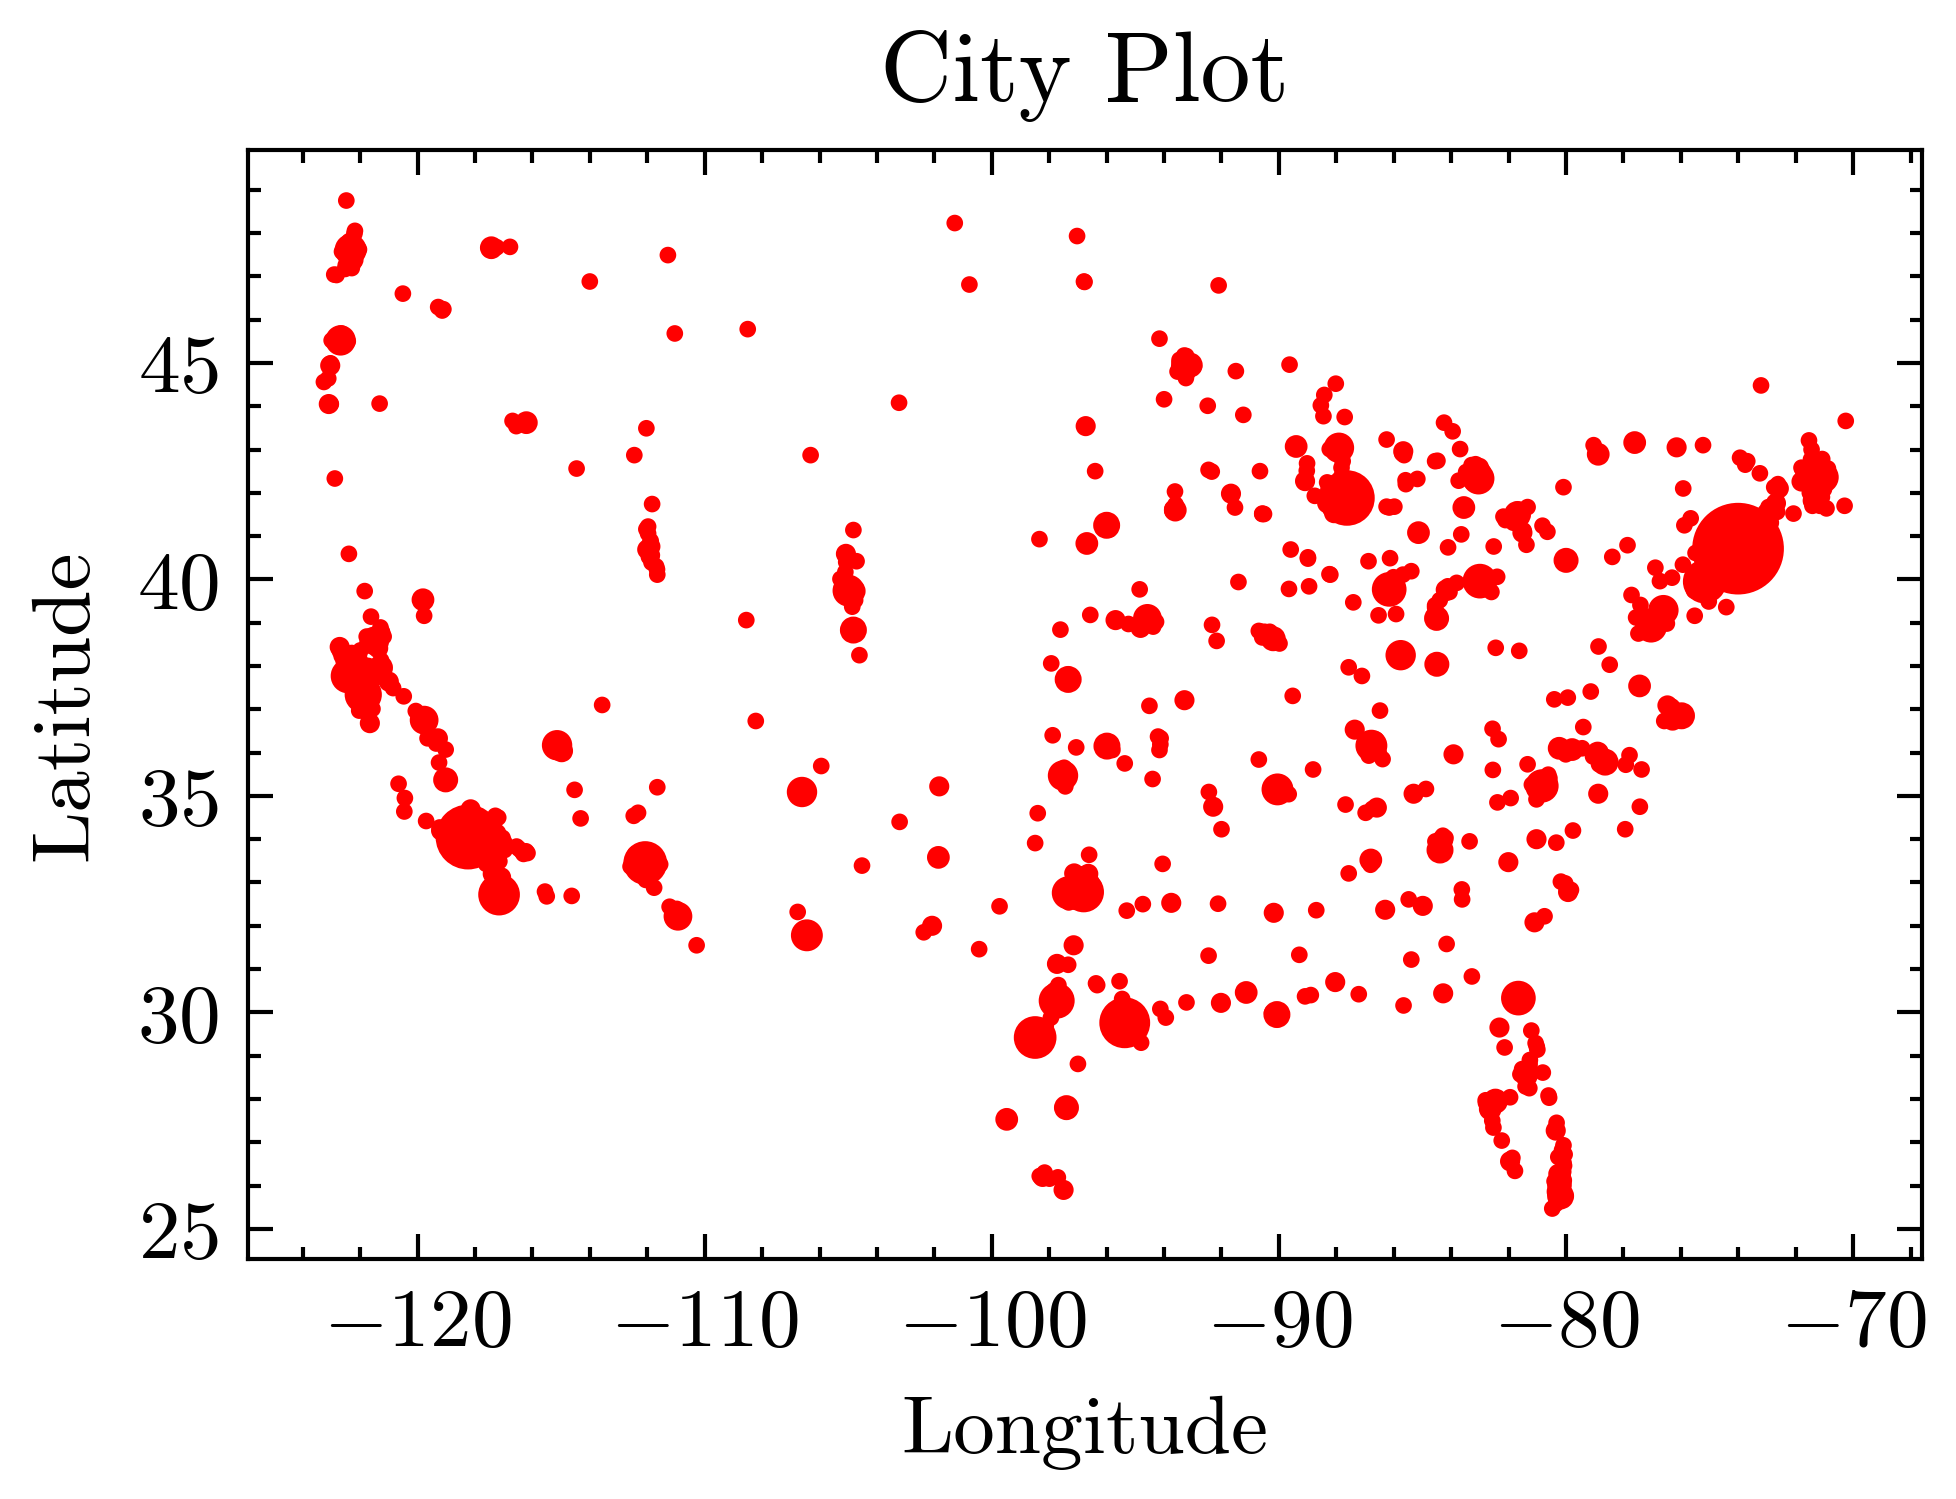

In [250]:
cities = read_cities("cities.txt")
cities = remove_outliers(cities)
plot_cities(cities)

In [251]:
def distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c # distance in km

def l2_distance(lat1, lon1, lat2, lon2):
    return math.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)


# Determine how redundant each city is based on other cities
def redundancy_1(cities, weight=2):
    r = np.zeros(len(cities))
    for i in range(len(cities)):
        for j in range(i + 1, len(cities)):
            ci = cities[i]
            cj = cities[j]
            lat1, lon1 = ci[1], ci[2]
            lat2, lon2 = cj[1], cj[2]
            d = distance(lat1, lon1, lat2, lon2)
            p1, p2 = ci[3], cj[3]
            # rscore = p2 / p1 * d ** -weight
            # rscore = np.log(rscore)
            rscore = np.log(p2 / p1) - weight * np.log(d)
            if p1 > p2:
                # r[j] += rscore
                # numpy log add trick
                r[j] = np.logaddexp(r[j], rscore)
            elif p2 > p1:
                r[i] = np.logaddexp(r[i], rscore)
    return r
    

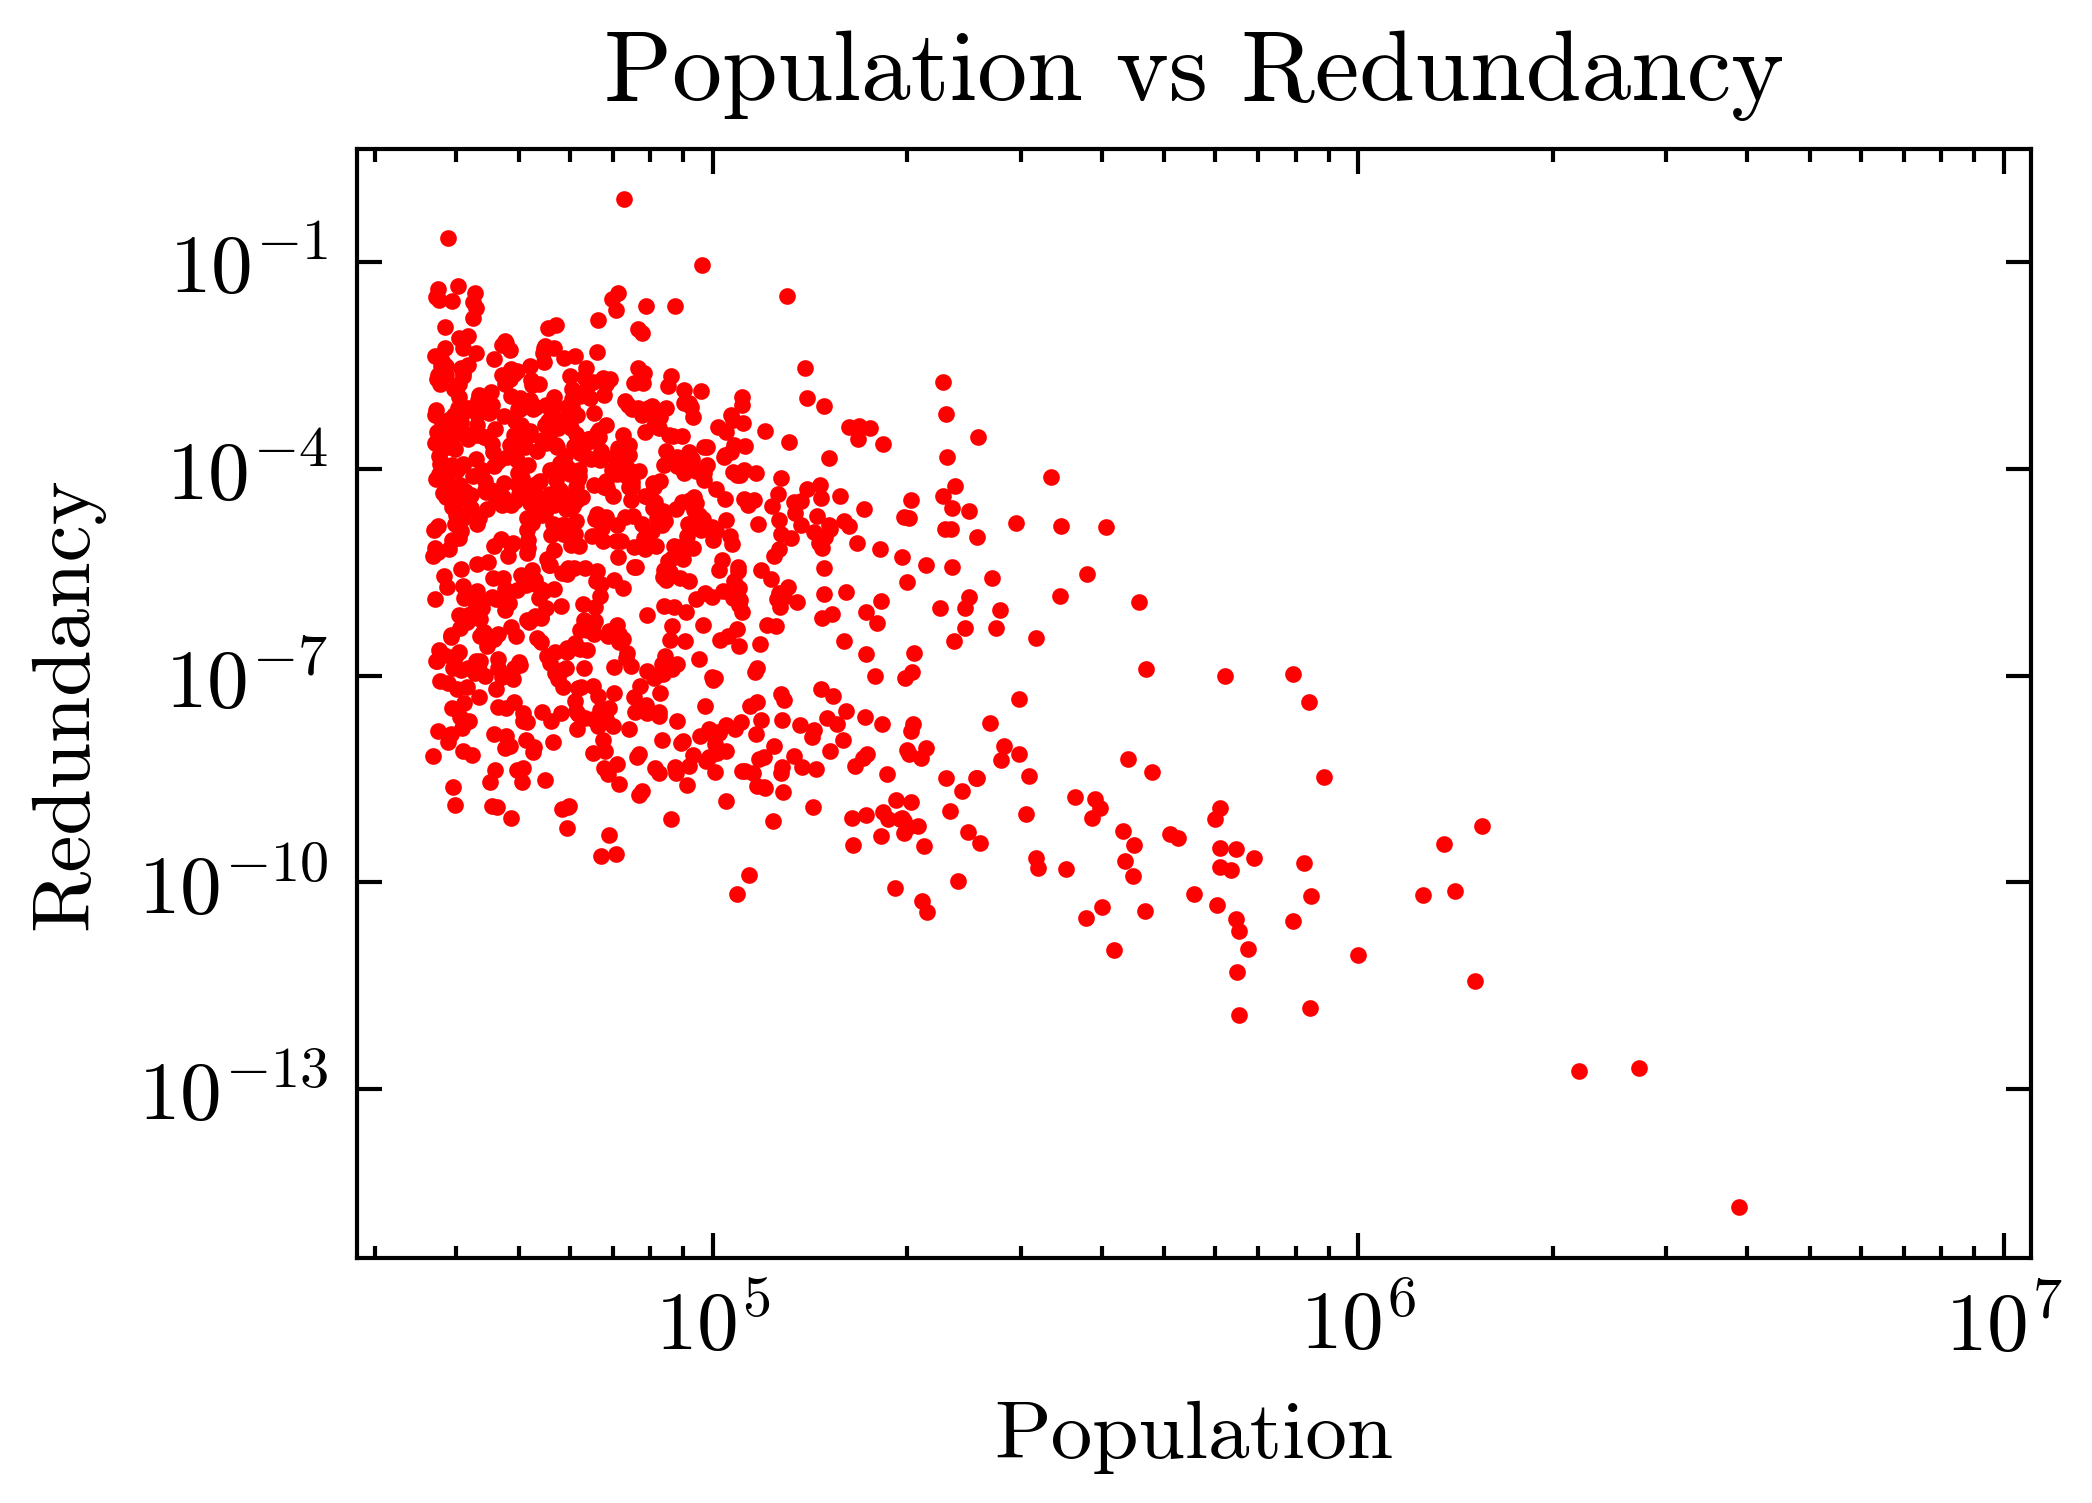

In [252]:
# keep the 100 most redundant cities
scores = redundancy_1(cities, 4)
pops = [x[3] for x in cities]
# plot graph between redundancy and population
plt.scatter(pops, scores, c="red", s=1)
plt.xlabel("Population")
plt.ylabel("Redundancy")
plt.yscale("log")
plt.xscale("log")
plt.title("Population vs Redundancy")
plt.show()

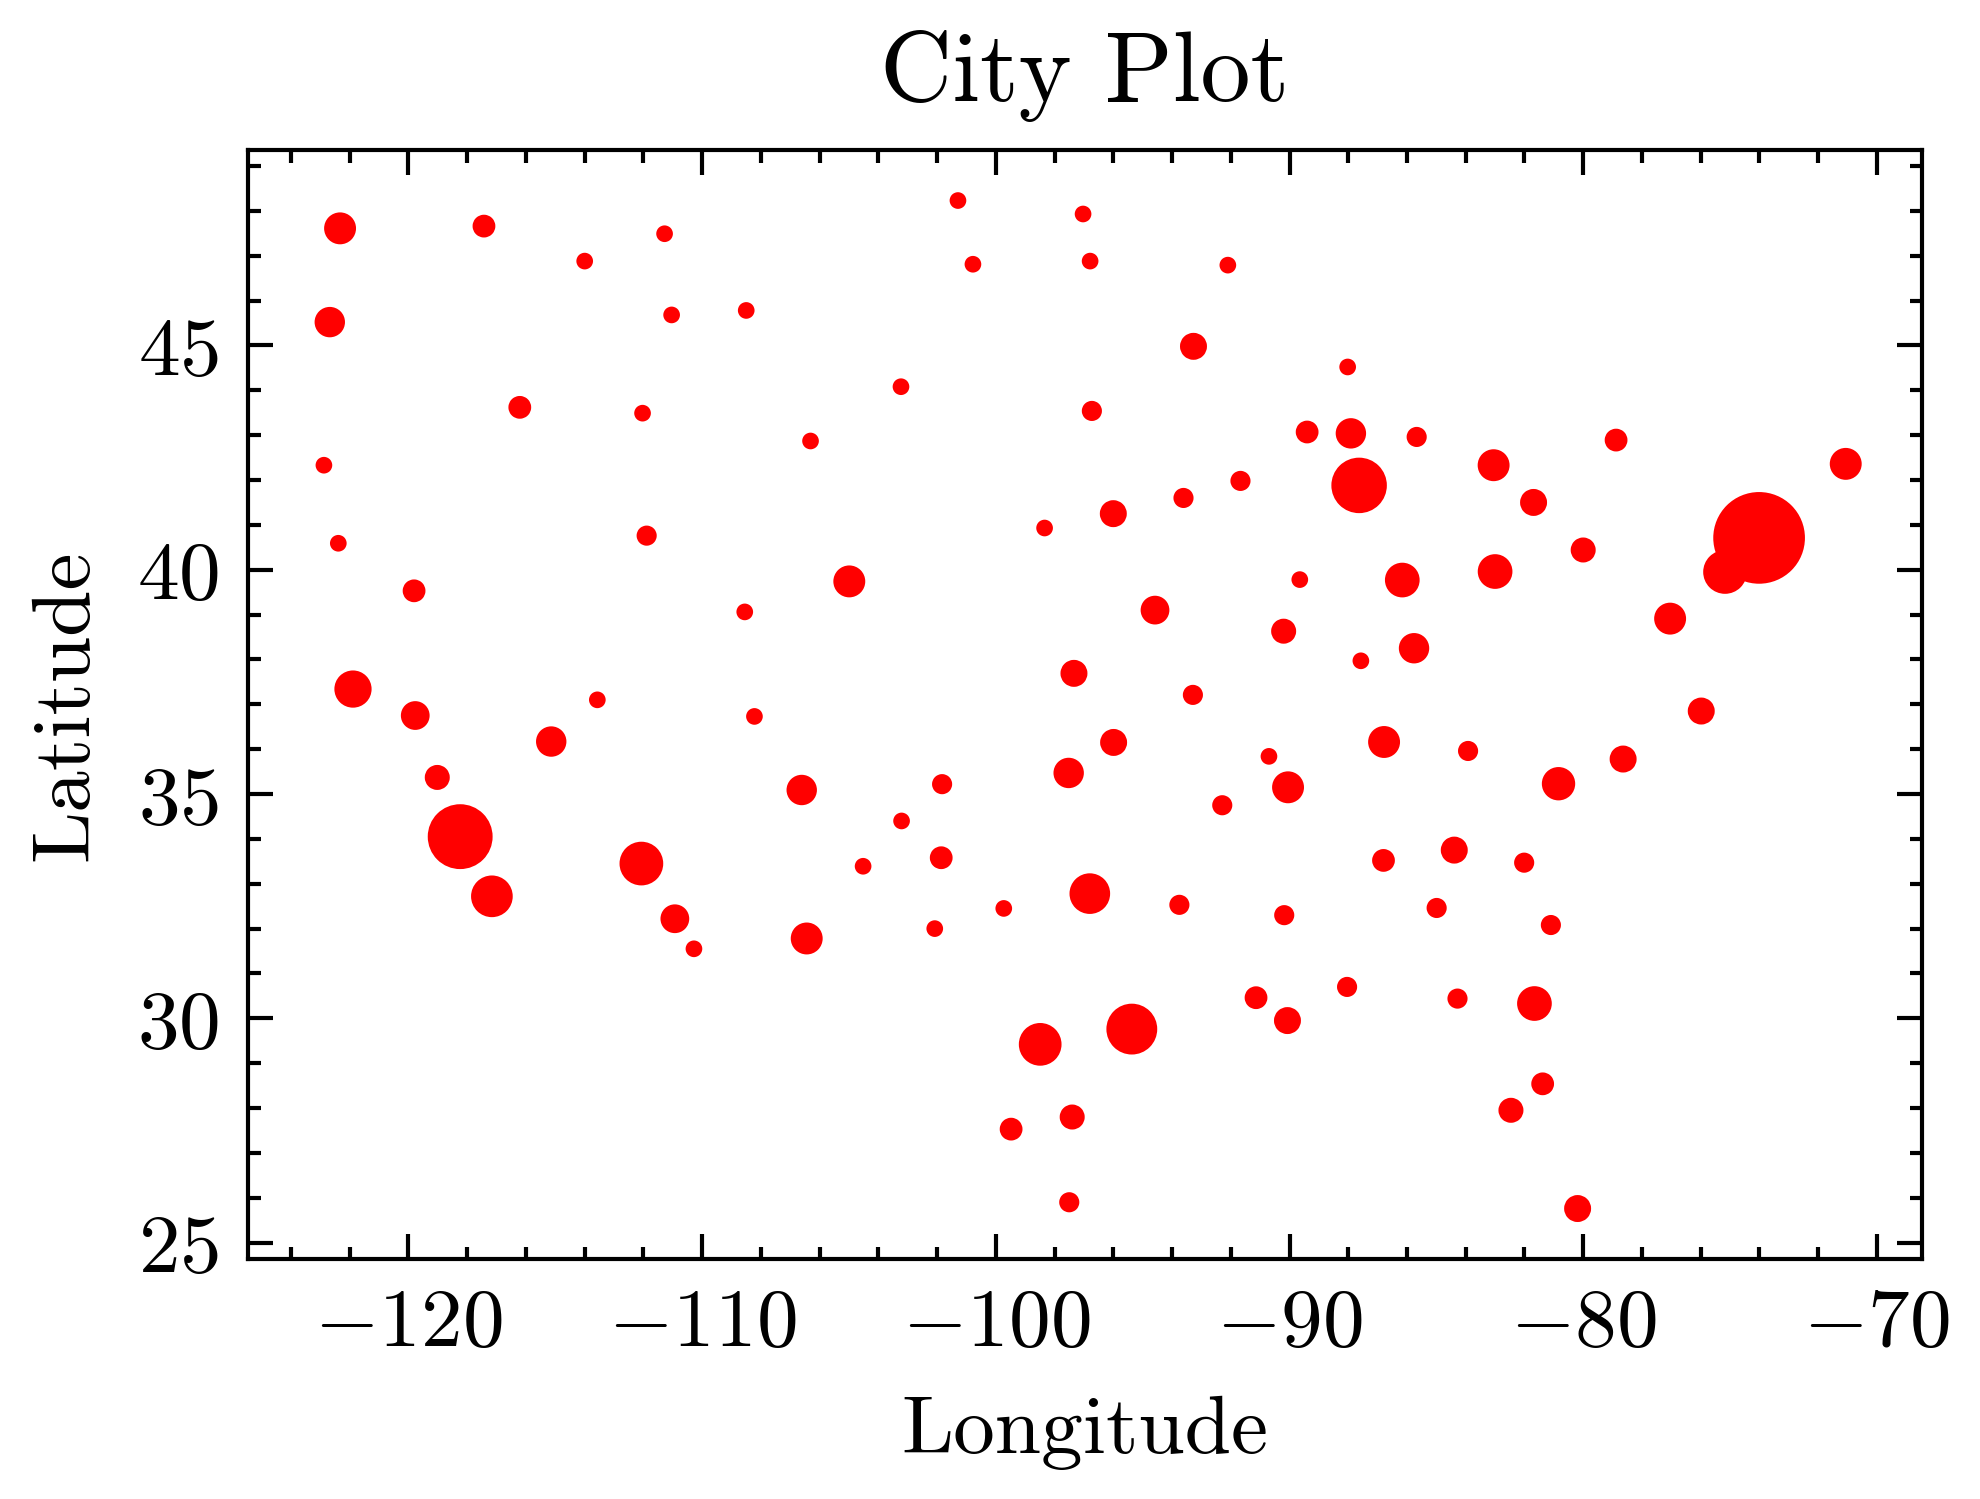

In [253]:
# keep the 100 least redundant cities
cities1 = [cities[i] for i in np.argsort(scores)[:100]]
plot_cities(cities1)

## Part 2: Algorithm

In [254]:
cities1[:5]

[('New_York', 40.71, -74.01, 8405837),
 ('Los_Angeles', 34.05, -118.24, 3884307),
 ('Houston', 29.76, -95.37, 2195914),
 ('Chicago', 41.88, -87.63, 2718782),
 ('Seattle', 47.61, -122.33, 652405)]

In [255]:
# get path length
def path_length(cities, p, full=False, distance=l2_distance):
    length = 0
    for i in range(len(p) - 1):
        c1 = cities[p[i]]
        c2 = cities[p[i + 1]]
        length += distance(c1[1], c1[2], c2[1], c2[2])
    if full:
        length += distance(cities[p[0]][1], cities[p[0]][2], cities[p[-1]][1], cities[p[-1]][2])
    return length

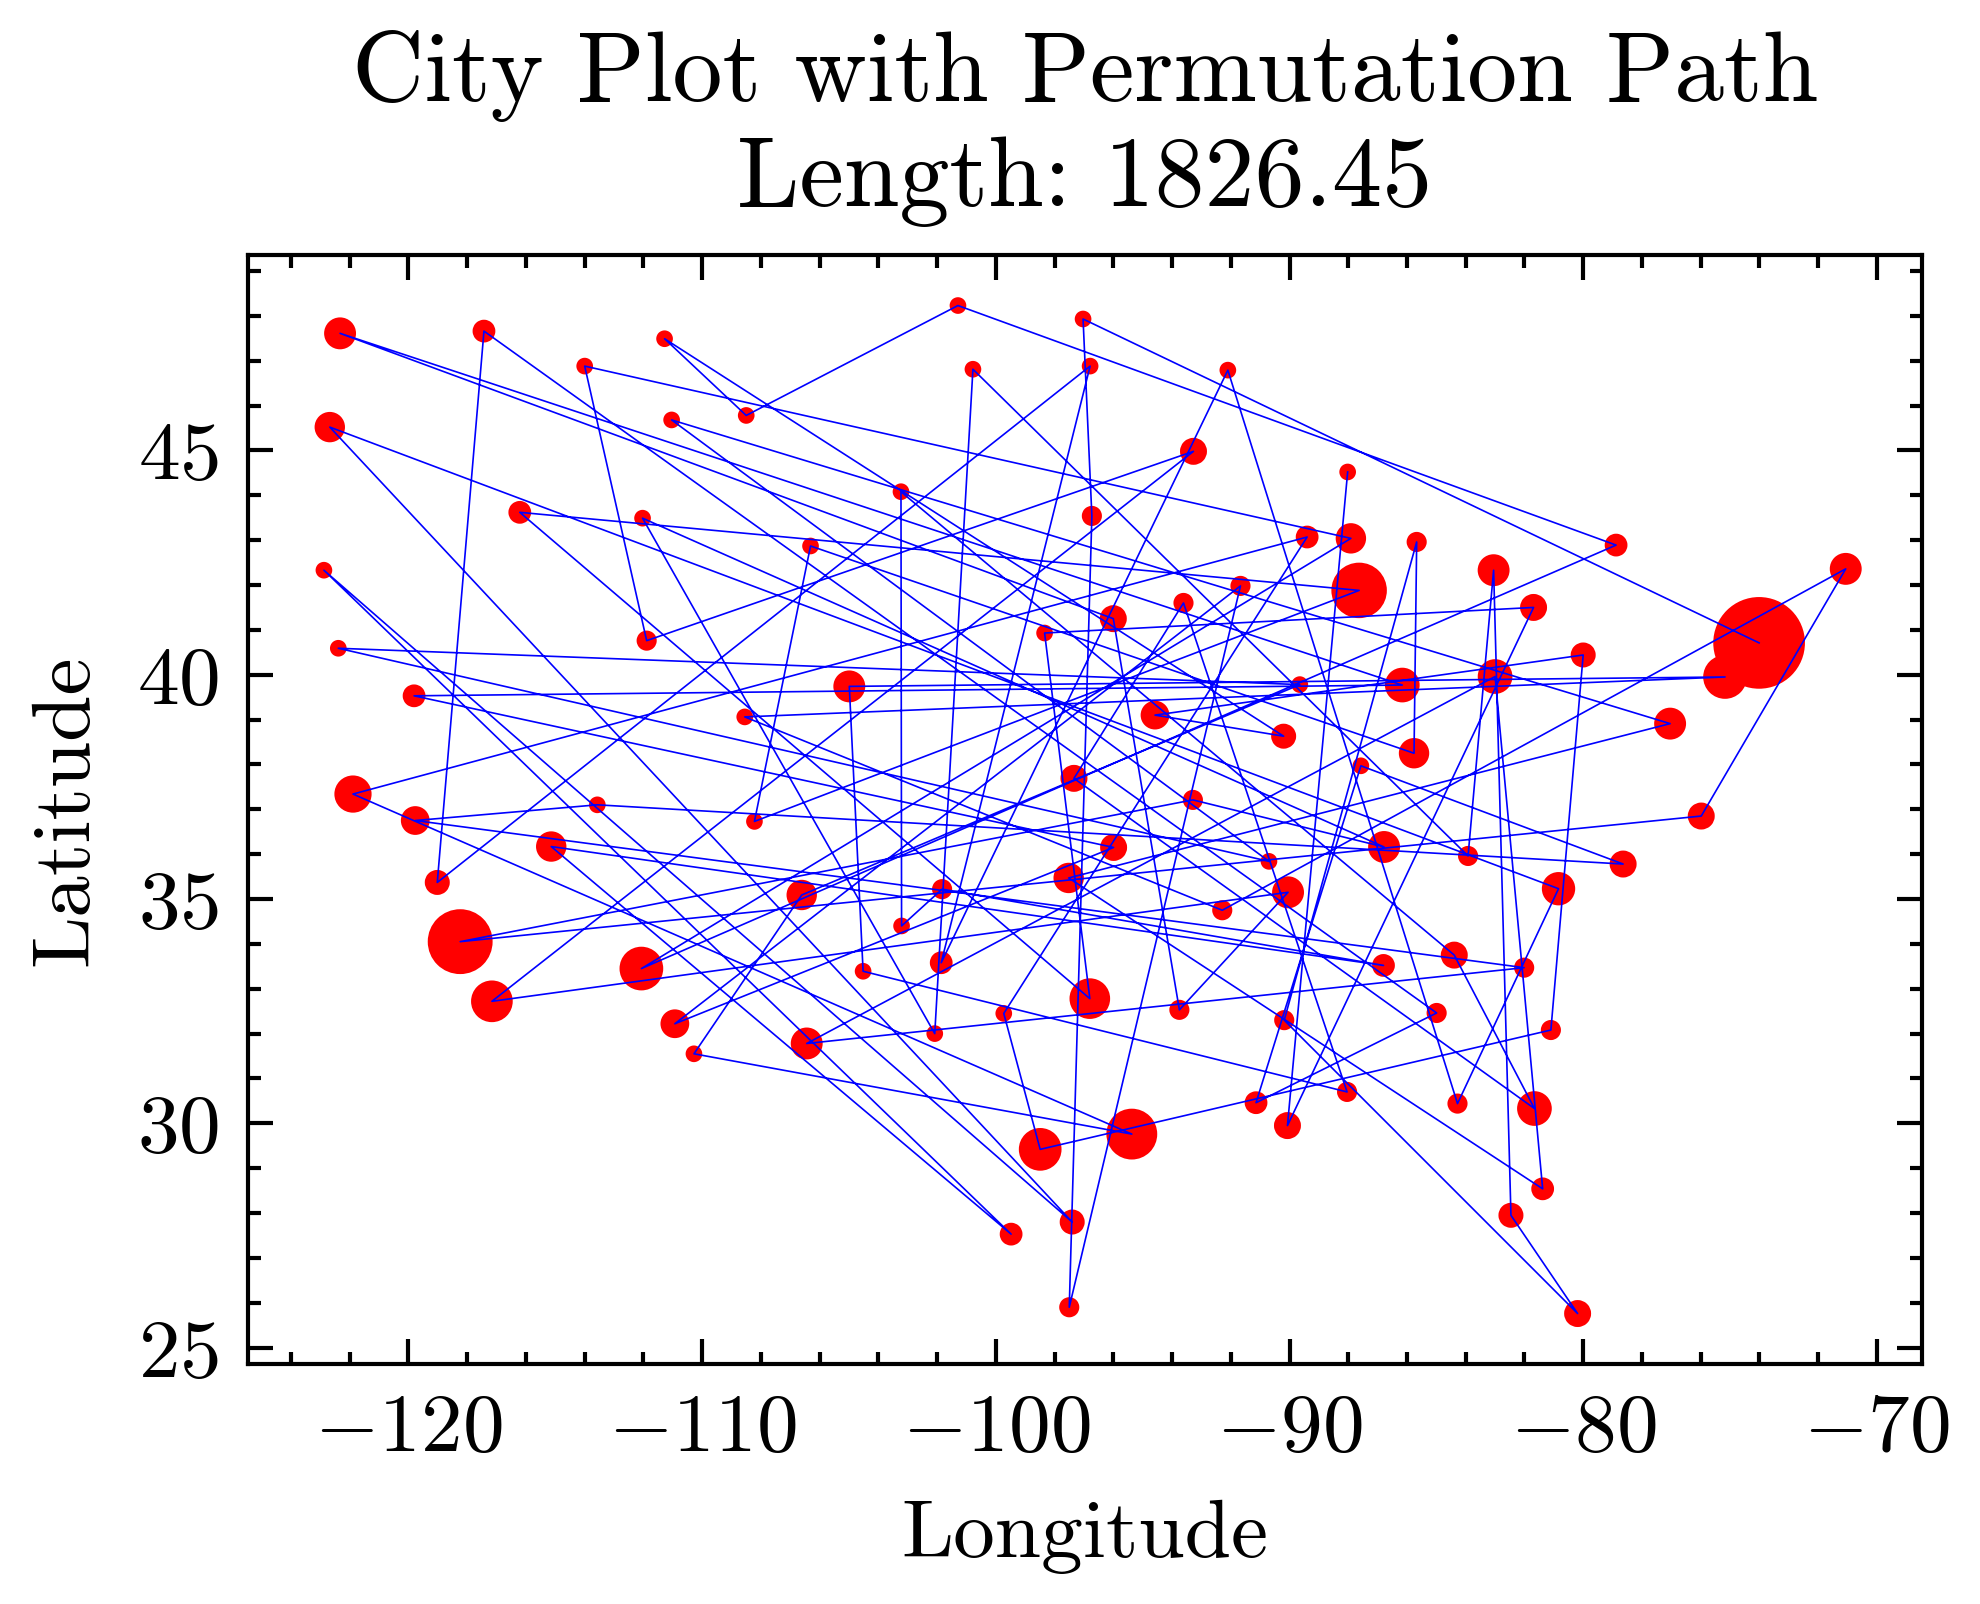

In [256]:
def plot_cities_permutation(cities, p):
    # get path length
    length = path_length(cities, p)
    # Extract cities in the order specified by permutation p
    permuted_cities = [cities[i] for i in p]
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    
    # Plot the cities as points
    plt.scatter(lons, lats, s=norm_pops, c="red")
    
    # Connect the cities in the order specified by permutation p
    plt.plot(lons, lats, linestyle='-', color='blue', linewidth=0.2)
    
    # Adding labels and title
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"City Plot with Permutation Path\nLength: {length:.2f}")
    plt.show()

p = np.random.permutation(len(cities1))
plot_cities_permutation(cities1, p)

In [258]:
def create_animation(cities, permutations, filename="tmp/cities_permutation.mp4"):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    # Pre-plot the cities as scatter points
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    scatter = ax.scatter(lons, lats, s=norm_pops, c="red")
    
    # Initialize the line object for updating
    line, = ax.plot([], [], linestyle='-', color='blue', linewidth=0.2)
    title = ax.text(0.5, 1.13, "City Plot with Permutation Path", transform=ax.transAxes, ha="center", fontsize=12)
    subtitle = ax.text(0.5, 1.03, "", transform=ax.transAxes, ha="center", fontsize=10)
    # frame_text = ax.text(0.02, 0.98, "", transform=ax.transAxes, ha="left", va="top", fontsize=10)
    
    def init():
        line.set_data([], [])
        subtitle.set_text("")
        # frame_text.set_text("")
        return line, subtitle

    def update(frame):
        start = time.time()
        p = permutations[frame]
        permuted_cities = [cities[i] for i in p]
        lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
        length = path_length(cities, p)
        
        line.set_data(lons, lats)
        subtitle.set_text(f"Length: {length:.2f}    Generation: {frame + 1}")
        # frame_text.set_text(f"Frame: {frame}")
        
        end = time.time()
        if frame % 10 == 0:
            print(f"Frame {frame} took {end - start:.2e} seconds")
        return line, subtitle

    ani = animation.FuncAnimation(fig, update, frames=len(permutations), init_func=init, blit=True, repeat=False)
    ani.save(filename, writer='ffmpeg', fps=10)
    plt.close()
    return filename

In [259]:
def test_create_animation():
    permutations = [np.random.permutation(len(cities1)) for _ in range(9)]
    fn = create_animation(cities1, permutations)
    print("Animation created successfully")
    # return Video(fn)


test_create_animation()

Frame 0 took 7.15e-04 seconds
Animation created successfully


In [260]:
def ordered_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end] = parent1[start:end]
    ptr = end
    for i in range(size):
        if parent2[(end + i) % size] not in child:
            child[ptr % size] = parent2[(end + i) % size]
            ptr += 1
    return child


def mutate(permutation, mutation_rate=0.01):
    l = len(permutation)  # subtract 1 because the last city is the same as the first city
    for i in range(l):
        if random.random() < mutation_rate:
            j = random.randint(0, l - 1)
            permutation[i], permutation[j] = permutation[j], permutation[i]


def genetic_algorithm(
    cities,
    population_size=100,
    generations=500,
    mutation_rate=0.01,
    mutation_decay_factor=1,
    r=0.1,
    full=True,
    initial_population=None,
    early_stopping_generations=10,
    cpu_count=None,
):
    assert 0 <= r <= 1
    assert population_size > 4
    _r = repr(
        {
            "population_size": population_size,
            "generations": generations,
            "mutation_rate": mutation_rate,
            "mutation_decay_factor": mutation_decay_factor,
            "r": r,
            "full": full,
            "initial_population": initial_population,
            "early_stopping_generations": early_stopping_generations,
            "cpu_count": cpu_count,
        }
    )
    print(f"Running genetic_algorithm with parameters: {_r}")

    # create a tmp directory to save results while running
    fn = f"tmp/geneticalgorithm/{time.strftime('%Y%m%d-%H%M%S')}"
    os.makedirs(fn, exist_ok=True)
    print(f"Saving results to {fn}")

    # Initialize population
    population = []
    if initial_population is not None:
        population.extend(initial_population)

    population += [np.random.permutation(len(cities)) for _ in range(population_size - len(population))]
    best_fitness = float("inf")
    fitness_history = []

    with ThreadPoolExecutor(max_workers=cpu_count) as executor:
        history = []
        with open(f"{fn}/log.txt", "w") as f:
            last_time = time.time()
            for generation in range(generations):
                # Calculate fitness
                fitness = list(executor.map(lambda p: path_length(cities, p, full=full), population))
                fitness_history.append(fitness)
                current_best_fitness = min(fitness)
                if current_best_fitness < best_fitness:
                    best_fitness = current_best_fitness

                print(
                    f"Generation {generation + 1}/{generations} (Fitness: {min(fitness):.2f} - {max(fitness):.2f} - {np.mean(fitness):.2f})",
                    end="\r",
                )
                sorted_indices = np.argsort(fitness)
                population = [population[i] for i in sorted_indices]

                # Save the best solution found so far
                history.append((generation, min(fitness), population[0]))
                print(f"{generation} {min(fitness):.2f} {population[0]}", file=f)
                curr_time = time.time()
                if curr_time - last_time > 4:
                    f.flush()
                last_time = curr_time

                if (generation + 1) % 20 == 0:
                    print()  # Print a newline every 10 generations
                # Early stopping criteria (if the fitness does not improve over 10 generations)
                if early_stopping_generations > -1:
                    if generation > early_stopping_generations and min(fitness_history[-1]) == min(
                        fitness_history[-early_stopping_generations]
                    ):
                        print()
                        print(f"Early stopping at generation {generation + 1}")
                        break

                # Selection
                num_best_to_keep = int(r * population_size)
                new_population = population[:num_best_to_keep]

                # Crossover and Mutation
                def crossover_and_mutate(parents):
                    child = ordered_crossover(parents[0], parents[1])
                    mutate(child, mutation_rate * mutation_decay_factor**generation)
                    return child

                parents_pairs = [
                    random.sample(population[: population_size // 2], 2)
                    for _ in range(population_size - num_best_to_keep)
                ]
                new_children = list(executor.map(crossover_and_mutate, parents_pairs))
                new_population.extend(new_children)

                population = new_population

    # Return the best solution found
    best_solution = population[0]
    best_length = path_length(cities, best_solution, full=full)
    if full:
        best_solution += best_solution[:1]
    return best_solution, best_length, history

In [261]:
# Run the genetic algorithm
best_permutation, best_length, hist = genetic_algorithm(
    cities1,
    mutation_rate=5e-4,
    mutation_decay_factor=0.1 ** (1 / 1000),
    generations=10000,
    r=0.3,
    population_size=3000,
    early_stopping_generations=200,
)

# Plot the best path found
plot_cities_permutation(cities1, best_permutation)

Running genetic_algorithm with parameters: {'population_size': 3000, 'generations': 10000, 'mutation_rate': 0.0005, 'mutation_decay_factor': 0.9977000638225533, 'r': 0.3, 'full': True, 'initial_population': None, 'early_stopping_generations': 200, 'cpu_count': None}
Saving results to tmp/geneticalgorithm/20240703-090942


KeyboardInterrupt: 

In [294]:
def load_history(filename):
    with open(filename, "r") as f:
        data = f.read()
    history = []
    for line in data.split("]\n"):
        if not line:
            continue
        generation, fitness, permutation = line.split(" ", 2)
        generation = int(generation)
        fitness = float(fitness)
        # print(permutation[1:-1])
        permutation = list(map(int, list(filter(lambda x: x, re.split(r",?\s", permutation[1:])))))
        history.append((generation, fitness, permutation))
    return history


hist2 = load_history("tmp/geneticalgorithm/20240702-115905/log.txt")

In [ ]:
create_animation(cities1, [x[2] for x in hist2], filename="tmp/geneticalgorithm/cities_permutation.mp4")

Frame 0 took 3.99e-04 seconds
Frame 10 took 2.77e-04 seconds
Frame 20 took 1.27e-04 seconds
Frame 30 took 1.52e-04 seconds
Frame 40 took 1.58e-04 seconds
Frame 50 took 1.32e-04 seconds
Frame 60 took 1.46e-04 seconds
Frame 70 took 1.42e-04 seconds
Frame 80 took 1.16e-04 seconds
Frame 90 took 1.56e-04 seconds
Frame 100 took 1.90e-04 seconds
Frame 110 took 1.64e-04 seconds
Frame 120 took 1.88e-04 seconds
Frame 130 took 4.43e-04 seconds
Frame 140 took 1.22e-04 seconds
Frame 150 took 1.37e-04 seconds
Frame 160 took 1.85e-04 seconds
Frame 170 took 1.25e-04 seconds
Frame 180 took 1.18e-04 seconds
Frame 190 took 1.23e-04 seconds
Frame 200 took 1.20e-04 seconds
Frame 210 took 1.36e-04 seconds
Frame 220 took 1.17e-04 seconds
Frame 230 took 1.22e-04 seconds
Frame 240 took 1.17e-04 seconds
Frame 250 took 1.34e-04 seconds
Frame 260 took 1.22e-04 seconds
Frame 270 took 1.14e-04 seconds
Frame 280 took 1.15e-04 seconds
Frame 290 took 1.16e-04 seconds
Frame 300 took 1.20e-04 seconds
Frame 310 took 1.33

'tmp/geneticalgorithm/cities_permutation.gif'

In [295]:
def filter_history(hist):
    hist_filtered = hist[:1]
    for h in hist:
        if not list(h[2]) == list(hist_filtered[-1][2]):
            hist_filtered.append(h)
    return hist_filtered

hist2_filtered = filter_history(hist2)
len(hist2), len(hist2_filtered)

(574, 190)

In [ ]:
create_animation(cities1, [x[2] for x in hist2_filtered], filename="tmp/geneticalgorithm/cities_permutation_filtered.mp4")

Frame 0 took 4.67e-04 seconds
Frame 10 took 1.57e-04 seconds
Frame 20 took 1.93e-04 seconds
Frame 30 took 2.30e-04 seconds
Frame 40 took 1.93e-04 seconds
Frame 50 took 1.45e-04 seconds
Frame 60 took 1.62e-04 seconds
Frame 70 took 1.62e-04 seconds
Frame 80 took 1.35e-04 seconds
Frame 90 took 1.57e-04 seconds
Frame 100 took 1.53e-04 seconds
Frame 110 took 1.38e-04 seconds
Frame 120 took 1.92e-04 seconds
Frame 130 took 2.75e-04 seconds
Frame 140 took 1.69e-04 seconds
Frame 150 took 3.02e-04 seconds
Frame 160 took 1.61e-04 seconds
Frame 170 took 1.37e-04 seconds
Frame 180 took 1.63e-04 seconds


'tmp/geneticalgorithm/cities_permutation_filtered.mp4'

In [ ]:
def create_animation(cities, permutations, filename="tmp/cities_permutation.mp4", steps_per_frame=6,ease_factor = 2):
    def interpolate_positions(start_positions, end_positions, alpha, ease_factor):
        # return start_positions * (1 - alpha) + end_positions * alpha
        # use ease in out
        for i in range(ease_factor):
            alpha = 0.5 - 0.5 * math.cos(alpha * math.pi)
        return start_positions * (1 - alpha) + end_positions * alpha

    fig, ax = plt.subplots()
    fig.set_tight_layout(True)

    # Pre-plot the cities as scatter points
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    scatter = ax.scatter(lons, lats, s=norm_pops, c="red")

    # Initialize the line object for updating
    (line,) = ax.plot([], [], linestyle="-", color="blue", linewidth=0.2)
    title = ax.text(0.5, 1.08, "City Plot with Permutation Path", transform=ax.transAxes, ha="center", fontsize=12)
    subtitle = ax.text(0.5, 1.03, "", transform=ax.transAxes, ha="center", fontsize=10)
    frame_text = ax.text(0.02, 0.98, "", transform=ax.transAxes, ha="left", va="top", fontsize=10)

    def init():
        line.set_data([], [])
        subtitle.set_text("")
        frame_text.set_text("")
        return line, subtitle, frame_text

    def update(frame):
        start = time.time()

        frame_num = frame // steps_per_frame
        alpha = (frame % steps_per_frame) / steps_per_frame

        p1 = permutations[frame_num][2]
        p2 = permutations[min(frame_num + 1, len(permutations) - 1)]

        cities1 = np.array([cities[i][1:3] for i in p1])
        cities2 = np.array([cities[i][1:3] for i in p2])

        interpolated_cities = interpolate_positions(cities1, cities2, alpha, ease_factor)

        lats, lons = interpolated_cities.T
        length = path_length(cities, p1)

        line.set_data(lons, lats)
        subtitle.set_text(f"Length: {length:.2f}")
        frame_text.set_text(f"Frame: {frame_num}")

        end = time.time()
        if frame % 10 == 0:
            print(f"Frame {frame} took {end - start:.2e} seconds")
        return line, subtitle, frame_text

    ani = animation.FuncAnimation(
        fig, update, frames=len(permutations) * steps_per_frame, init_func=init, blit=True, repeat=False
    )
    ani.save(filename, writer="ffmpeg", fps=30)
    plt.close()
    return filename

In [ ]:
create_animation(
    cities1,
    hist_filtered[::20],
    filename="tmp/geneticalgorithm/cities_permutation_filtered_interpolated.mp4",
    steps_per_frame=5,
    ease_factor=2,
)

Frame 0 took 8.21e-04 seconds
Frame 10 took 5.33e-04 seconds
Frame 20 took 5.51e-04 seconds
Frame 30 took 2.20e-04 seconds
Frame 40 took 2.44e-04 seconds


'tmp/geneticalgorithm/cities_permutation_filtered_interpolated.mp4'

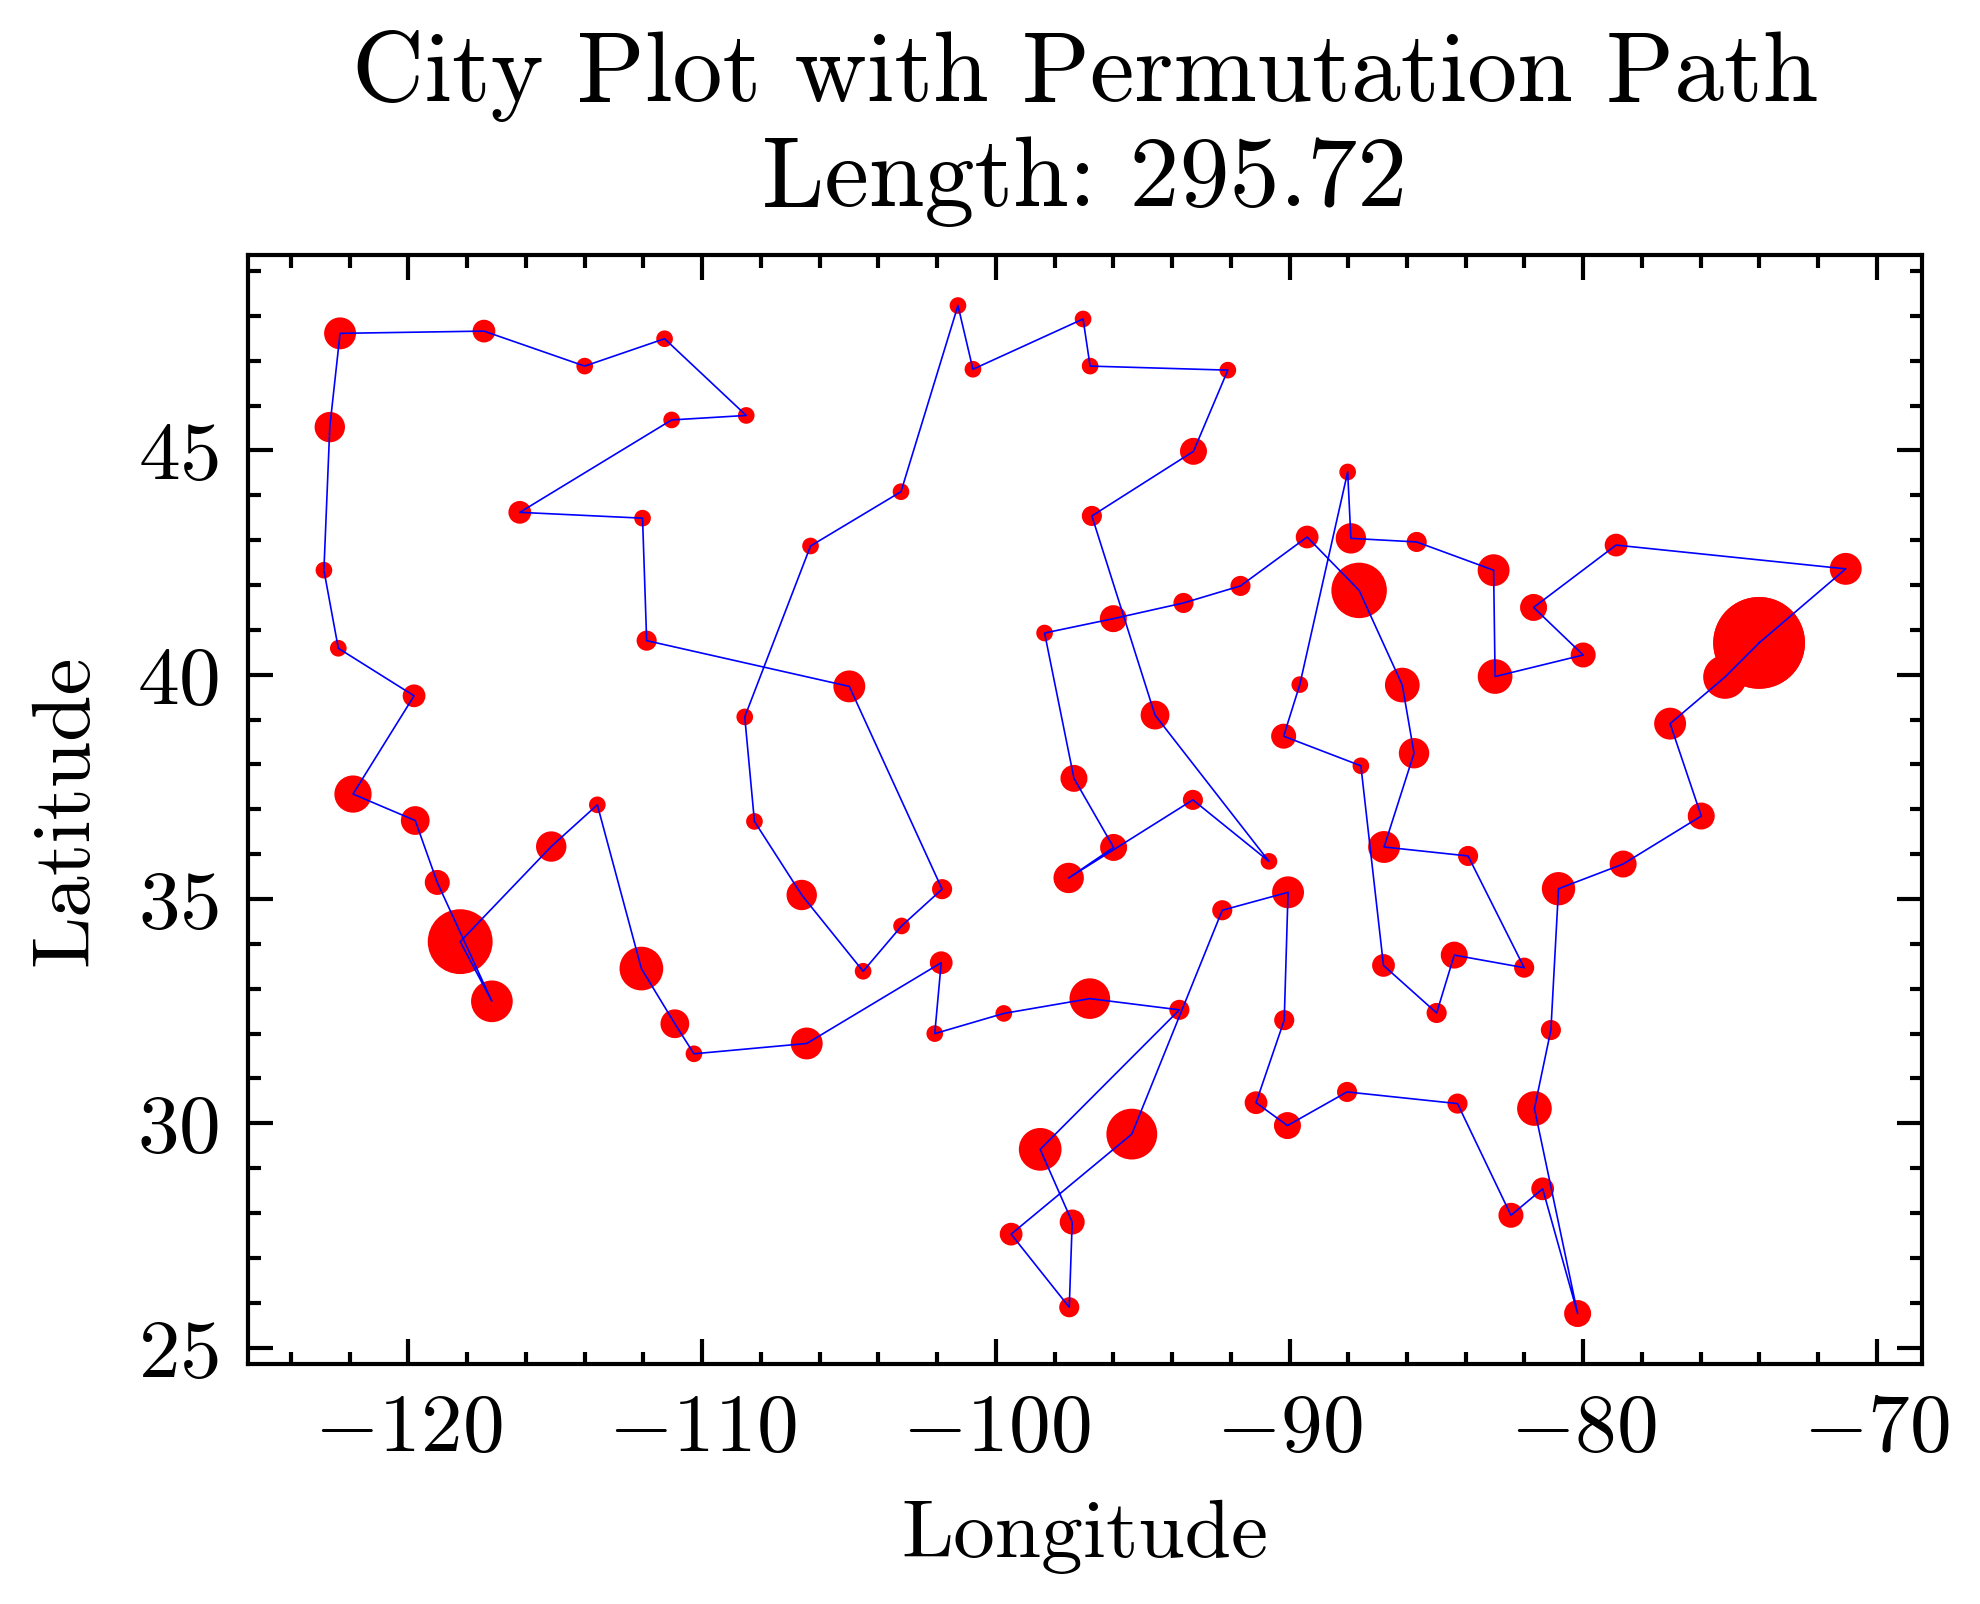

In [109]:
# Christofides algorithm implementation
def christofides(cities):
    # Create a complete graph with distances as edge weights
    G = nx.Graph()
    for i, c1 in enumerate(cities):
        for j, c2 in enumerate(cities):
            if i != j:
                G.add_edge(i, j, weight=distance(c1[1], c1[2], c2[1], c2[2]))

    # Step 1: Find the Minimum Spanning Tree (MST)
    MST = nx.minimum_spanning_tree(G)

    # Step 2: Find the vertices with odd degree in the MST
    odd_degree_nodes = [v for v, d in MST.degree() if d % 2 == 1]

    # Step 3: Find the minimum weight perfect matching for the odd degree vertices
    odd_subgraph = G.subgraph(odd_degree_nodes)
    matching = nx.algorithms.matching.min_weight_matching(odd_subgraph)

    # Combine the matching and the MST to form a multigraph
    multigraph = nx.MultiGraph()
    multigraph.add_edges_from(MST.edges)
    multigraph.add_edges_from(matching)

    # Step 4: Form an Eulerian circuit from the multigraph
    eulerian_circuit = list(nx.eulerian_circuit(multigraph))

    # Step 5: Create a Hamiltonian circuit by shortcutting repeated vertices
    visited = set()
    path = []
    for u, v in eulerian_circuit:
        if u not in visited:
            visited.add(u)
            path.append(u)
    path.append(path[0])  # Closing the loop

    return path

# Run the Christofides algorithm
best_path = christofides(cities1)
best_length = path_length(cities1, best_path, full=True)

# Plot the best path found
plot_cities_permutation(cities1, best_path)

In [110]:
best_permutation, best_length, hist1 = genetic_algorithm(
    cities1,
    mutation_rate=3e-4,
    generations=1000,
    r=0.1,
    population_size=2000,
    early_stopping_generations=100,
    initial_population=[best_path[:-1]]*1900,
    cpu_count=10000
)

# Plot the best path found
plot_cities_permutation(cities1, best_permutation)

Running genetic_algorithm with parameters: {'population_size': 2000, 'generations': 1000, 'mutation_rate': 0.0003, 'mutation_decay_factor': 1, 'r': 0.1, 'full': True, 'initial_population': [[0, 13, 45, 83, 68, 33, 36, 82, 61, 81, 92, 31, 89, 41, 80, 27, 58, 69, 29, 73, 20, 3, 88, 86, 55, 34, 95, 63, 72, 32, 64, 94, 16, 43, 17, 59, 28, 97, 37, 76, 38, 75, 78, 77, 23, 65, 91, 66, 7, 25, 71, 15, 79, 22, 53, 48, 19, 4, 40, 87, 93, 70, 8, 49, 84, 44, 1, 18, 85, 6, 46, 96, 10, 26, 57, 90, 21, 54, 24, 35, 47, 51, 2, 50, 11, 67, 98, 14, 60, 62, 30, 99, 9, 5, 74, 12, 52, 42, 39, 56], [0, 13, 45, 83, 68, 33, 36, 82, 61, 81, 92, 31, 89, 41, 80, 27, 58, 69, 29, 73, 20, 3, 88, 86, 55, 34, 95, 63, 72, 32, 64, 94, 16, 43, 17, 59, 28, 97, 37, 76, 38, 75, 78, 77, 23, 65, 91, 66, 7, 25, 71, 15, 79, 22, 53, 48, 19, 4, 40, 87, 93, 70, 8, 49, 84, 44, 1, 18, 85, 6, 46, 96, 10, 26, 57, 90, 21, 54, 24, 35, 47, 51, 2, 50, 11, 67, 98, 14, 60, 62, 30, 99, 9, 5, 74, 12, 52, 42, 39, 56], [0, 13, 45, 83, 68, 33, 36

KeyboardInterrupt: 

In [ ]:
print(best_permutation, best_length)

[13, 188, 115, 129, 45, 109, 169, 68, 83, 36, 153, 100, 156, 82, 3, 149, 88, 61, 81, 170, 161, 191, 111, 17, 59, 28, 97, 76, 37, 38, 75, 145, 7, 128, 179, 183, 23, 77, 78, 25, 113, 15, 71, 79, 22, 53, 48, 19, 139, 136, 4, 40, 117, 162, 87, 93, 194, 70, 110, 8, 187, 49, 197, 84, 172, 176, 1, 44, 122, 152, 18, 85, 104, 6, 46, 96, 143, 10, 65, 91, 66, 26, 57, 125, 90, 148, 32, 193, 63, 196, 166, 195, 95, 190, 34, 105, 43, 55, 86, 173, 171, 92, 163, 20, 177, 33, 141, 102, 73, 181, 29, 165, 89, 159, 31, 182, 108, 16, 64, 72, 106, 50, 94, 11, 116, 103, 41, 140, 80, 131, 160, 27, 133, 58, 135, 120, 74, 5, 107, 99, 186, 130, 9, 123, 30, 158, 62, 147, 134, 144, 60, 124, 150, 67, 114, 155, 54, 175, 174, 21, 121, 24, 51, 185, 47, 35, 142, 101, 168, 2, 127, 180, 154, 98, 14, 146, 167, 138, 69, 199, 119, 12, 126, 52, 189, 112, 157, 132, 118, 164, 151, 42, 39, 56, 198, 0, 178, 137, 184, 192, 13] 32937.791375092864


In [ ]:
len(best_permutation)

201

Running Genetic Algorithm with population size 50, generations 643, mutation rate 0.0003, and r 0.1
Saving results to tmp/geneticalgorithm/20240702-113602
Generation 20/643 (Fitness: 65.03 - 85.79 - 75.11)))
Generation 40/643 (Fitness: 49.90 - 65.66 - 56.92)
Generation 60/643 (Fitness: 46.84 - 56.66 - 48.26)
Generation 80/643 (Fitness: 46.67 - 46.67 - 46.67)

Early stopping at generation 80


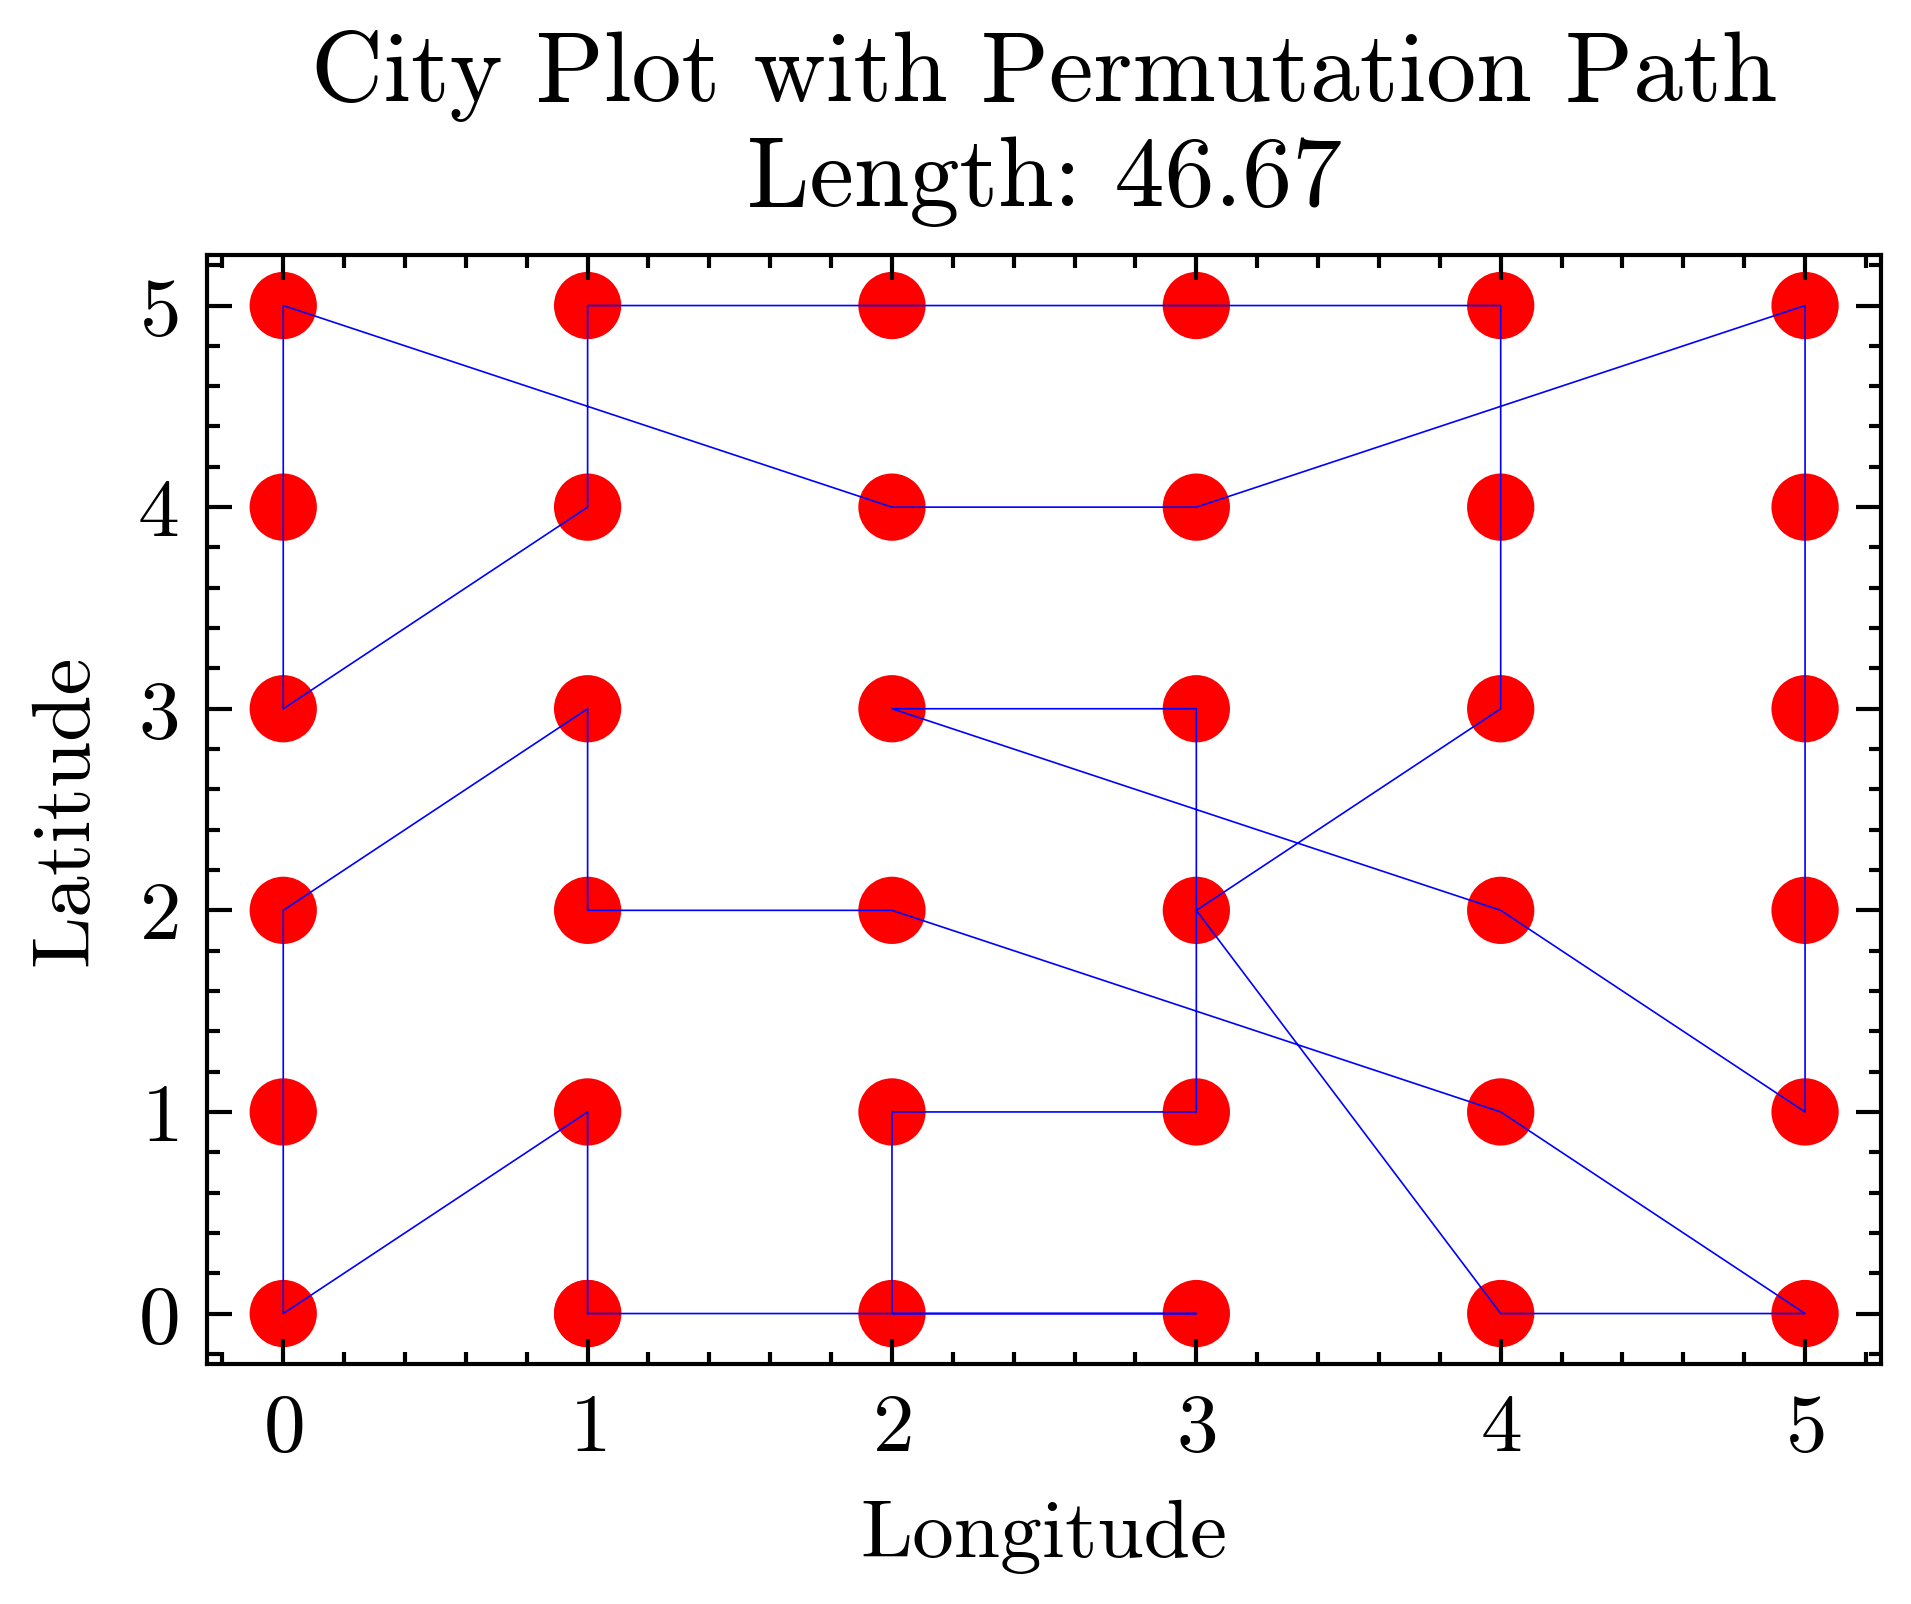

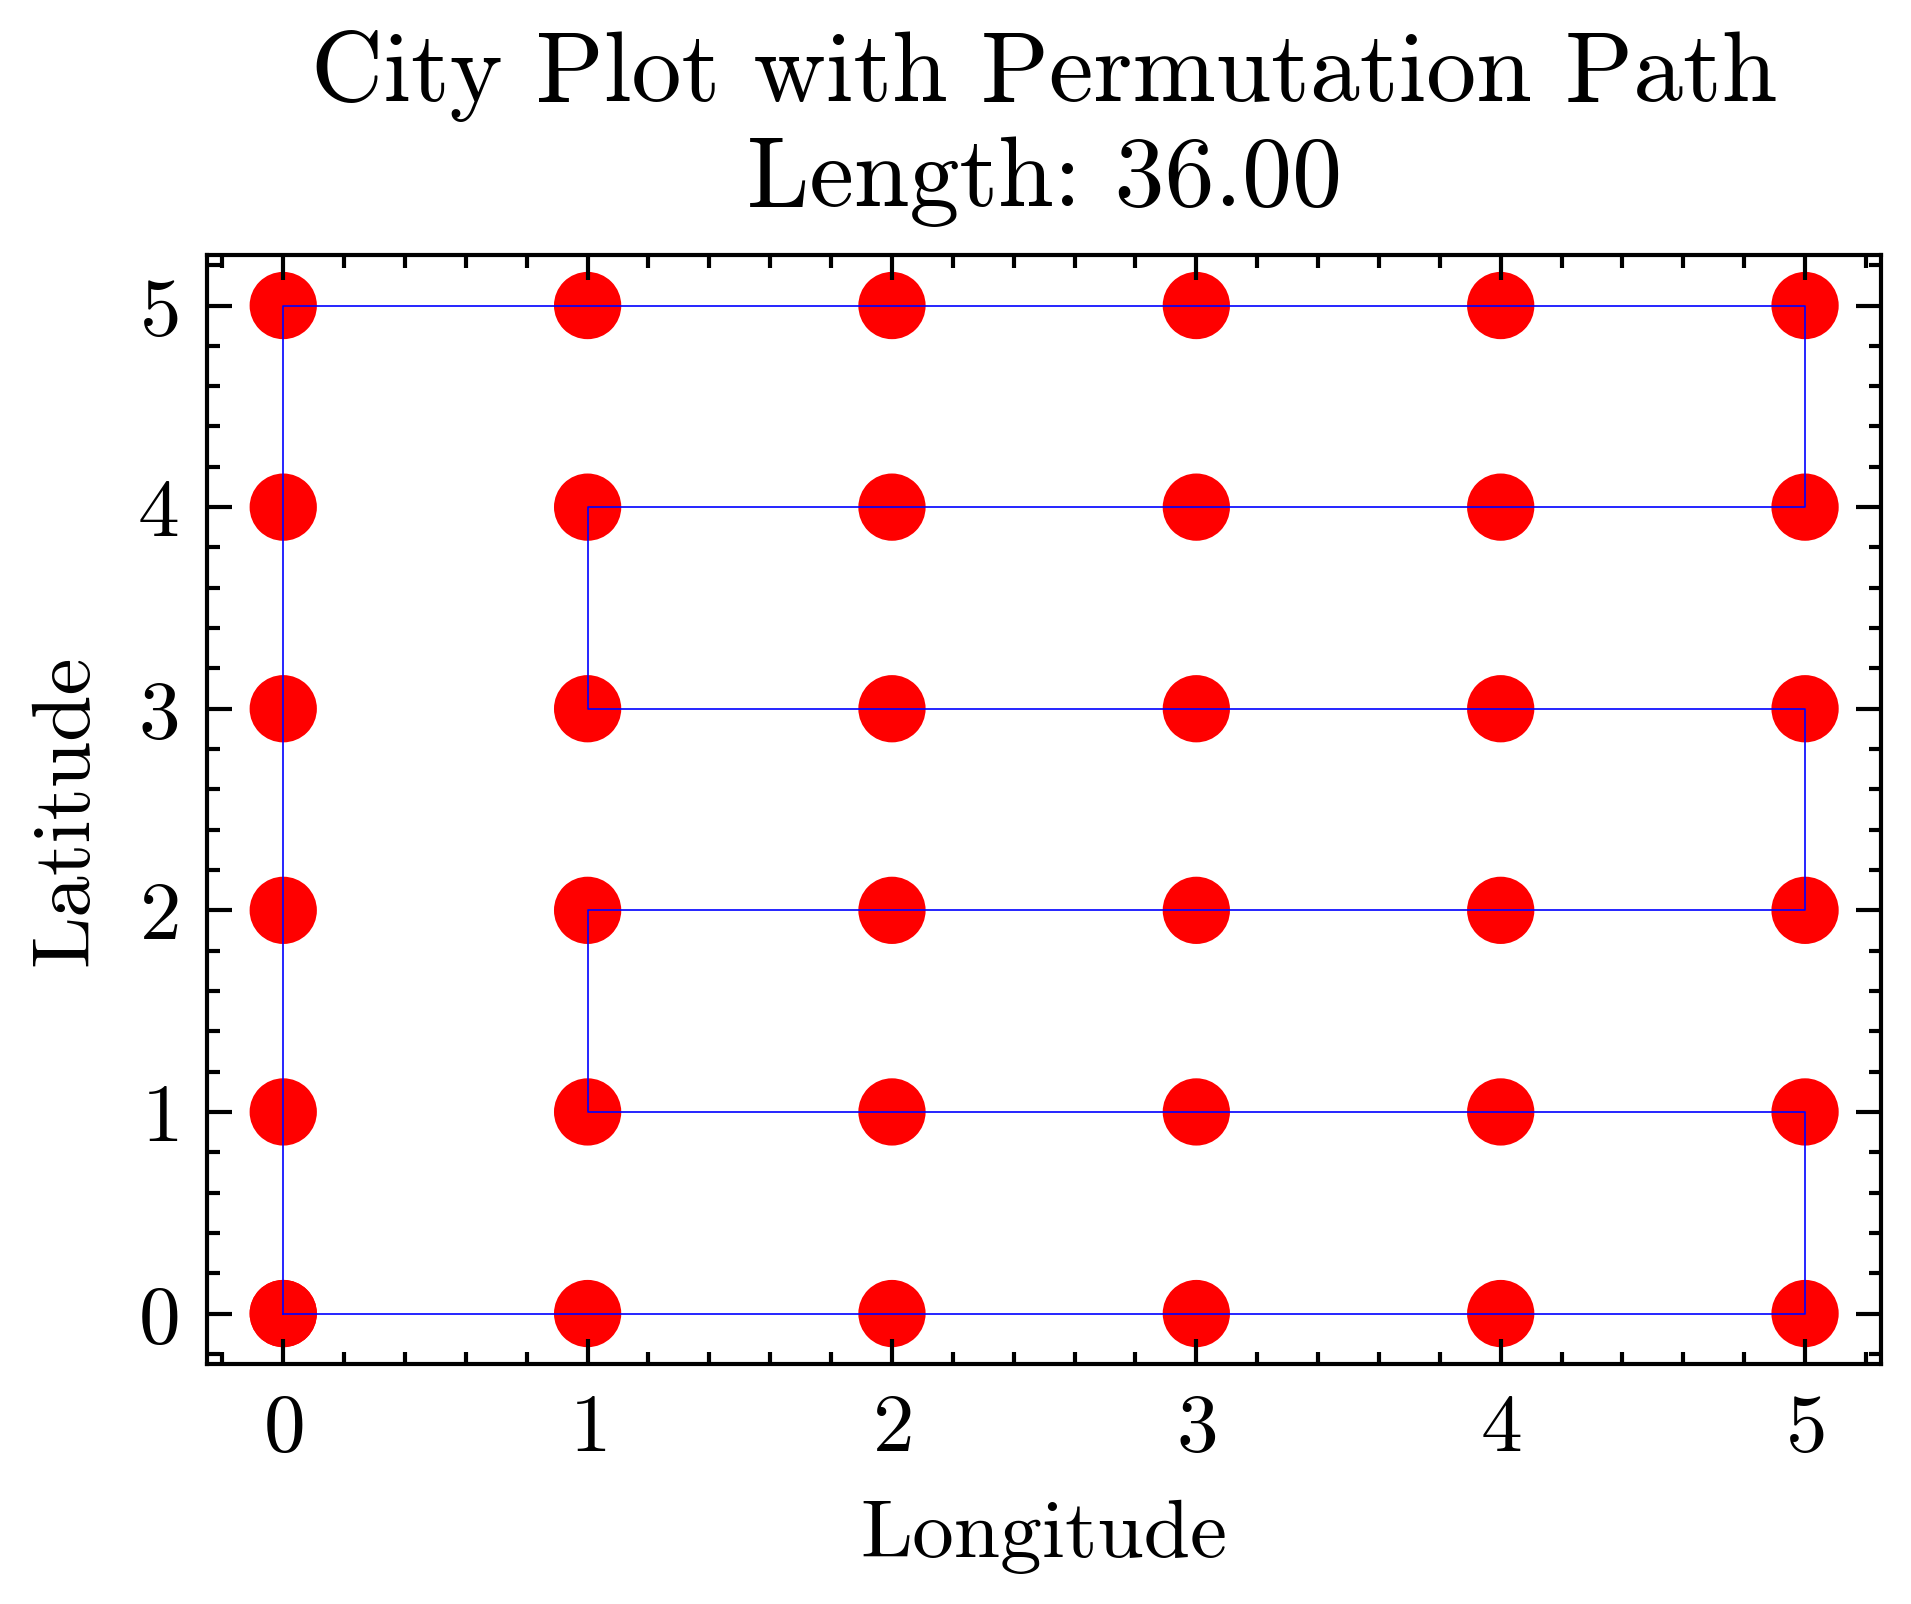

In [ ]:
def test_blocks():
    cities = [(f"C{i+1}", i // 6, i % 6, 10) for i in range(6**2)]
    plot_cities_permutation(
        cities,
        genetic_algorithm(
            cities,
            mutation_rate=3e-4,
            generations=643,
            population_size=50,
            early_stopping_generations=20,
        )[0]
    )
    plot_cities_permutation(cities, christofides(cities))

test_blocks()